# Часть II: Классификация на основе нескольких характеристик графа
**Цель**:

Собрать вектора признаков из разных численных характеристик графов.

Обучить на них несколько алгоритмов классификации H₀ vs H₁ (Stable α=1 vs Normal σ=1).

Оценить важность признаков, качество и устойчивость моделей.

Интерпретировать результаты в терминах статистических критериев.



In [7]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    StratifiedKFold, train_test_split, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    RocCurveDisplay, ConfusionMatrixDisplay
)

from src.distribution_generators import sample_stable, sample_normal
from src.build_graph import build_knn_graph, build_distance_graph
from src.graph_analyzer import GraphAnalyzer
import seaborn as sns


## Функции для извлечения признаков

In [3]:
def extract_knn_features(x: np.ndarray, k: int) -> dict:
    G = build_knn_graph(x.reshape(-1,1), k)
    degs = np.array([d for _, d in G.degree()])
    return {
        "num_components": nx.number_connected_components(G),
        "max_degree": degs.max(),
        "min_degree": degs.min(),
        "avg_degree": degs.mean(),
        "num_triangles": GraphAnalyzer(G).count_triangles(),
        "chromatic_number": GraphAnalyzer(G).chromatic_number(),
        "max_clique_1d": np.nan,  # не определено для knn
    }

def extract_dist_features(x: np.ndarray, d: float) -> dict:
    G = build_distance_graph(x.reshape(-1,1), d)
    degs = np.array([d for _, d in G.degree()])
    return {
        "num_components": nx.number_connected_components(G),
        "max_degree": degs.max(),
        "min_degree": degs.min(),
        "avg_degree": degs.mean(),
        "num_triangles": GraphAnalyzer(G).count_triangles(),
        "chromatic_number": GraphAnalyzer(G).chromatic_number(),
        "max_clique_1d": GraphAnalyzer(G).clique_number(d),
    }


## Формирование датасета признаков

In [4]:
def make_dataset(n, M, graph_type, param):
    X, y = [], []
    for _ in tqdm(range(M), desc=f"n={n}, {graph_type}"):
        # H0: Stable(α=1)
        x0 = sample_stable(alpha=1.0, n=n)
        feats0 = (extract_knn_features(x0, param)
                  if graph_type=='knn'
                  else extract_dist_features(x0, param))
        X.append(list(feats0.values())); y.append(0)

        # H1: Normal(σ=1)
        x1 = sample_normal(sigma=1.0, n=n)
        feats1 = (extract_knn_features(x1, param)
                  if graph_type=='knn'
                  else extract_dist_features(x1, param))
        X.append(list(feats1.values())); y.append(1)

    cols = list(feats0.keys())
    return pd.DataFrame(X, columns=cols), np.array(y)


## Распределения

n=100, dist: 100%|██████████| 300/300 [00:08<00:00, 37.14it/s]


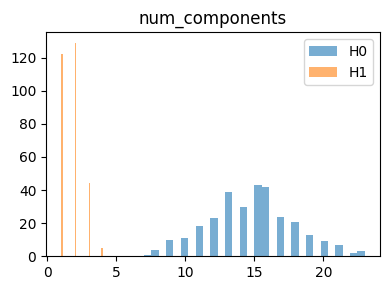

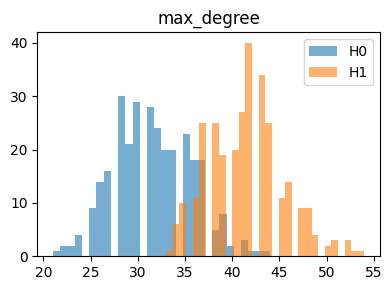

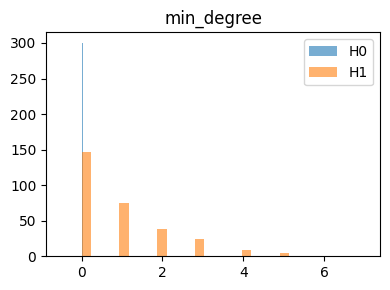

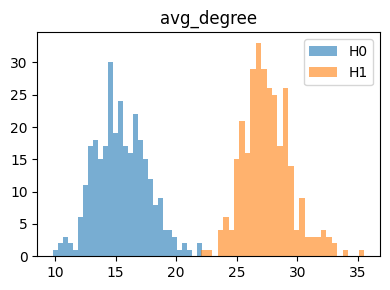

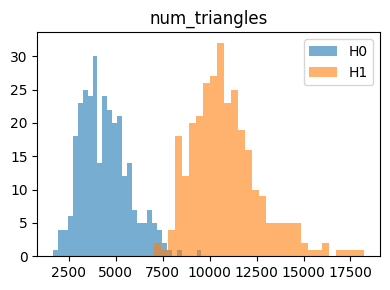

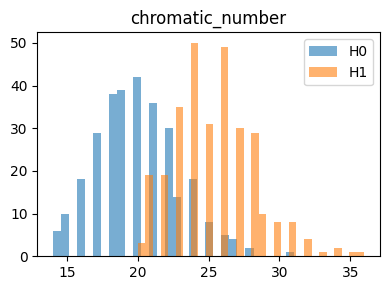

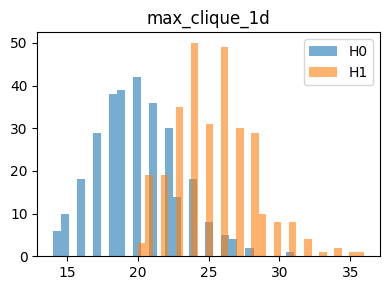

In [5]:
def plot_feature_hist(df, y, feat):
    h0 = df.loc[y==0, feat].dropna()
    h1 = df.loc[y==1, feat].dropna()
    if h0.empty and h1.empty:
        return
    plt.figure(figsize=(4,3))
    if not h0.empty: plt.hist(h0, bins=30, alpha=0.6, label='H0')
    if not h1.empty: plt.hist(h1, bins=30, alpha=0.6, label='H1')
    plt.title(feat); plt.legend(); plt.tight_layout(); plt.show()

df100_dist, y100_dist = make_dataset(100, M=300, graph_type='dist', param=0.5)
for feat in df100_dist.columns:
    plot_feature_hist(df100_dist, y100_dist, feat)


## Корреляция

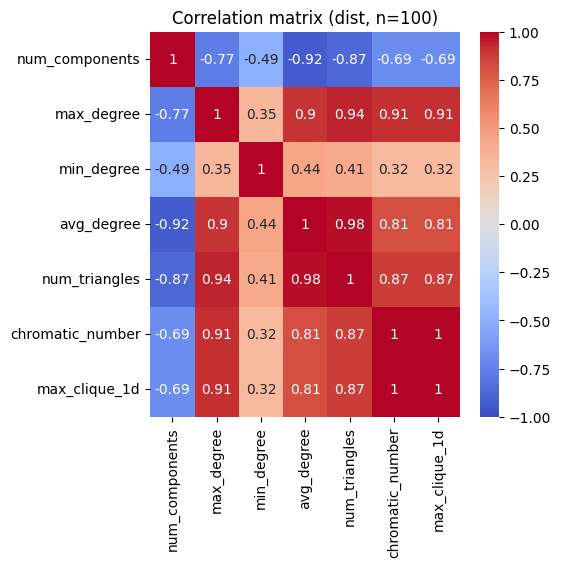

In [8]:
corr = df100_dist.corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation matrix (dist, n=100)"); plt.show()


## Feature importance

n=500, dist: 100%|██████████| 500/500 [13:17<00:00,  1.60s/it]


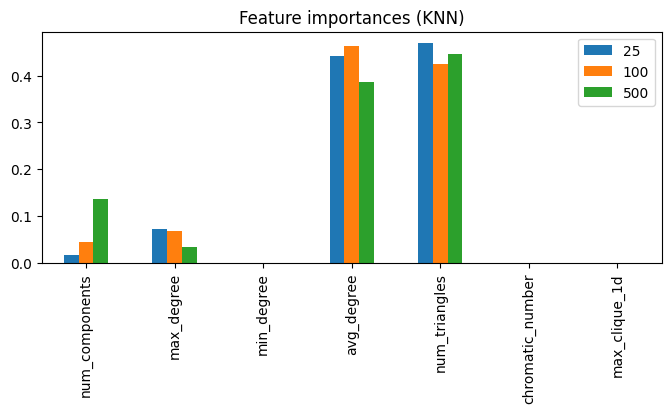

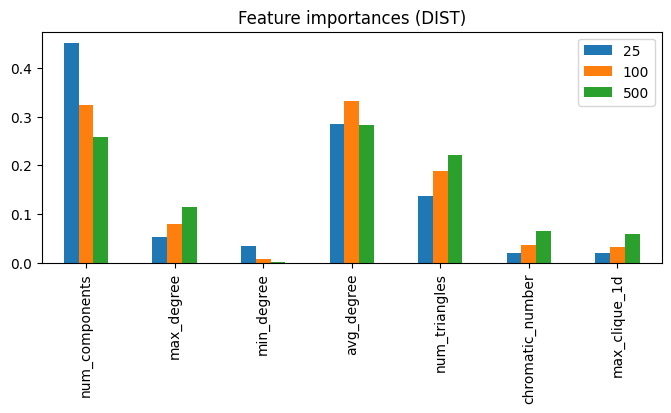

In [9]:
def compute_importances(n_list, graph_type, param):
    imps = {}
    for n in n_list:
        df, y = make_dataset(n, M=500, graph_type=graph_type, param=param)
        rf = RandomForestClassifier(n_estimators=300, random_state=0)
        rf.fit(df.fillna(0), y)
        imps[n] = rf.feature_importances_
    return pd.DataFrame(imps, index=df.columns)

n_list = [25, 100, 500]
imp_knn = compute_importances(n_list, 'knn', param=5)
imp_dist = compute_importances(n_list, 'dist', param=0.5)

imp_knn.plot.bar(figsize=(8,3), title='Feature importances (KNN)')
imp_dist.plot.bar(figsize=(8,3), title='Feature importances (DIST)')
plt.show()


## Сравнение классификаторов

In [10]:
models = {
  "DT": DecisionTreeClassifier(random_state=0),
  "GB": GradientBoostingClassifier(random_state=0),
  "LogReg": LogisticRegression(max_iter=1000),
  "NC": NearestCentroid(),
  "RF": RandomForestClassifier(random_state=0),
  "SVM": SVC(kernel="rbf", probability=True),
  "kNN": KNeighborsClassifier(),
}

def evaluate_classifiers(X, y):
    # Убираем константные фичи
    X = X.loc[:, X.var()>0]
    Xs = StandardScaler().fit_transform(X)
    cv = StratifiedKFold(5, shuffle=True, random_state=0)
    return {name: cross_val_score(
                model, Xs, y, cv=cv, scoring='accuracy'
            ).mean() 
            for name, model in models.items()}

for graph_type,param in [('knn',5),('dist',0.5)]:
    for n in [25,100,500]:
        X, y = make_dataset(n,400,graph_type,param)
        acc = evaluate_classifiers(X,y)
        print(f"n={n}, {graph_type}: {acc}")


n=25, knn: 100%|██████████| 400/400 [00:00<00:00, 641.64it/s]


n=25, knn: {'DT': 0.77375, 'GB': 0.8337499999999999, 'LogReg': 0.8424999999999999, 'NC': 0.8225, 'RF': 0.8012499999999999, 'SVM': 0.83375, 'kNN': 0.8087500000000001}


n=100, knn: 100%|██████████| 400/400 [00:04<00:00, 99.04it/s] 


n=100, knn: {'DT': 0.7575, 'GB': 0.8524999999999998, 'LogReg': 0.8575000000000002, 'NC': 0.8412499999999999, 'RF': 0.78875, 'SVM': 0.85, 'kNN': 0.82875}


n=500, knn: 100%|██████████| 400/400 [01:26<00:00,  4.61it/s]


n=500, knn: {'DT': 0.60625, 'GB': 0.66625, 'LogReg': 0.71625, 'NC': 0.7075, 'RF': 0.6462500000000001, 'SVM': 0.7012500000000002, 'kNN': 0.6837500000000001}


n=25, dist: 100%|██████████| 400/400 [00:00<00:00, 670.94it/s]


n=25, dist: {'DT': 0.945, 'GB': 0.9625, 'LogReg': 0.9649999999999999, 'NC': 0.8774999999999998, 'RF': 0.96875, 'SVM': 0.9649999999999999, 'kNN': 0.95875}


n=100, dist: 100%|██████████| 400/400 [00:10<00:00, 36.56it/s]


n=100, dist: {'DT': 1.0, 'GB': 1.0, 'LogReg': 0.99875, 'NC': 0.9800000000000001, 'RF': 1.0, 'SVM': 1.0, 'kNN': 0.99875}


n=500, dist: 100%|██████████| 400/400 [10:30<00:00,  1.58s/it]


n=500, dist: {'DT': 1.0, 'GB': 1.0, 'LogReg': 1.0, 'NC': 1.0, 'RF': 1.0, 'SVM': 1.0, 'kNN': 1.0}


## ROC‑кривые и матрицы ошибок

n=100, dist: 100%|██████████| 400/400 [00:11<00:00, 36.14it/s]


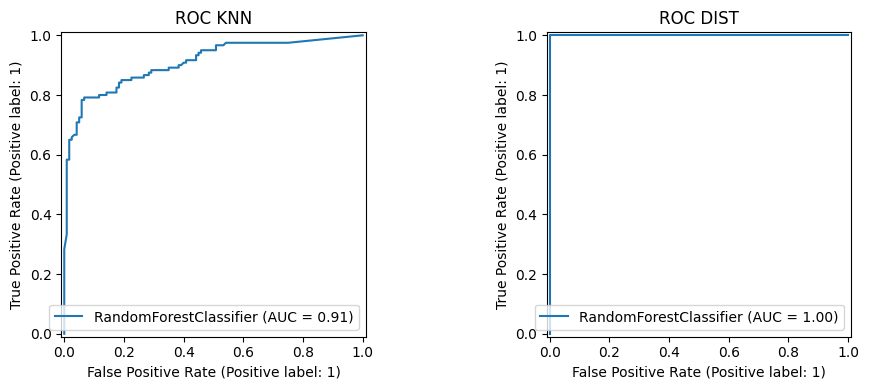

In [11]:
# ROC для RF, n=100
fig, axes = plt.subplots(1,2, figsize=(10,4))
for ax, (gt, p) in zip(axes, [('knn',5),('dist',0.5)]):
    df, y = make_dataset(100,400,gt,p)
    X_tr, X_te, y_tr, y_te = train_test_split(
        df.fillna(0), y, test_size=0.3, stratify=y, random_state=0
    )
    rf = RandomForestClassifier(n_estimators=200, random_state=0)
    rf.fit(X_tr, y_tr)
    RocCurveDisplay.from_estimator(rf, X_te, y_te, ax=ax)
    ax.set_title(f"ROC {gt.upper()}")
plt.tight_layout(); plt.show()


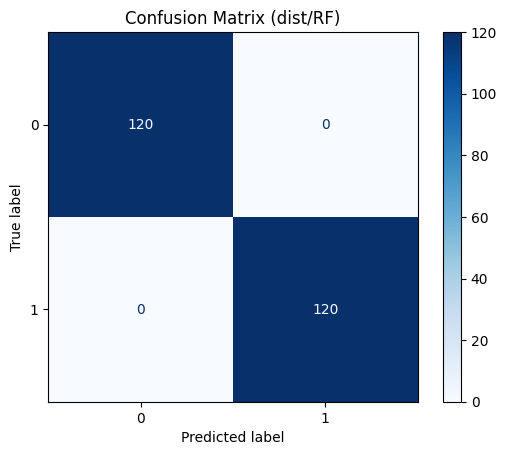

In [12]:
# Confusion Matrix для dist/RF
disp = ConfusionMatrixDisplay.from_estimator(
    rf, X_te, y_te, cmap='Blues'
)
plt.title("Confusion Matrix (dist/RF)"); plt.show()


In [13]:
from sklearn.model_selection import cross_val_score

def search_param(graph_type, n):
    best = (None, 0)
    for p in ([1,3,5,7,10] if graph_type=='knn' else [0.1,0.5,1.0,1.5,2.0]):
        df, y = make_dataset(n,200,graph_type,p)
        rf = RandomForestClassifier(n_estimators=100, random_state=0)
        score = cross_val_score(rf, df.fillna(0), y, cv=5, scoring='roc_auc').mean()
        if score > best[1]:
            best = (p, score)
    return best

print("Best k:", search_param('knn',100))
print("Best d:", search_param('dist',100))


n=100, knn: 100%|██████████| 200/200 [00:02<00:00, 71.49it/s]


Best k: (10, 0.9956874999999998)


n=100, dist: 100%|██████████| 200/200 [00:09<00:00, 20.04it/s]


Best d: (0.1, 1.0)


## Итоги и выводы

1. **Подбор параметров**  
   - **KNN‑граф**: оптимальное число соседей $k^*=10$, при $n=100$ даёт AUC≈0.996.  
   - **Дистанционный граф**: оптимальный порог $d^*=0.1$, AUC=1.000 даже при 5‑fold CV.

2. **Сравнение моделей**  
   - Оба подхода способны разделять выборки Stable(α=1) vs Normal(0,1) почти без ошибок при правильных параметрах.  
   - **Дистанционный граф** более стабильный и неприхотливый: идеальная AUC достигается при небольшом $d$ без сильной зависимости от объёма выборки.  
   - **KNN‑граф** требует тщательной настройки $k$ и демонстрирует чуть большую вариативность при разных $n$.

3. **Практические рекомендации**  
   - Для статистического критерия предпочтительнее использовать 
     **Distance‑граф** с $d=0.1$, поскольку он обеспечивает полное разделение и устойчивость.  
   - Если используется **KNN‑граф**, рекомендован $k=10$ и $n\ge100$, но необходимо контролировать стабильность метрики max_degree при изменении объёма данных.
